In [3]:
from google.colab import drive 
drive.mount('/content/drive')
%cd drive/MyDrive/MASTER_THESIS/Codes/clean_nb
!ls

Mounted at /content/drive
/content/drive/MyDrive/MASTER_THESIS/Codes/clean_nb
BC_combined_train.ipynb  models			      myTrajNPP.ipynb
BC_TrajGAN.ipynb	 myMARC_TUL.ipynb	      spatialindex-src-1.8.5
data			 myTrajGAN_furtherExp.ipynb   training_params
figures			 myTrajGAN.ipynb	      utils
further_exp		 myTrajNPP_further_exp.ipynb


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random
import time

# Utils

In [5]:
def traj_percentage(df, p=100):
    return df[df.tid.isin(                                                  
                [df_train[df_train.uid==i].tid.unique()[j]                  
                 for i in df_train.uid.unique() 
                 for j in range(
                     int(p/100*len(df_train[df_train.uid==i].tid.unique())))
                 ])].reset_index(drop=True).copy()

In [6]:
from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preproc_trajnpp(df_train, df_test):
  df_train, df_test = df_train.copy(), df_test.copy()

  data = [df_train, df_test]
  df = pd.concat([df_train, df_test], ignore_index=True, copy=False) # just for checking features

  # Dict for sizes
  vocab_sizes = {i:df[i].unique().size+1 for i in df.columns[:]}
  vocab_sizes['max_len'] = df.groupby('tid').count().max()[0]
  vocab_sizes['lat_lon'] = 2

  # Dict for encoding
  vocab_encod = {}
  for j in df.columns[-3:]: # day, hour, poi 
    vocab_encod[j] = {sorted(df[j].unique())[i-1]:i for i in range(1,df[j].unique().size+1)} # starting from 1 (zero is mask)

  # Dict for coords centroids
  vocab_centroid = {}
  vocab_centroid['lat'] = df['lat'].mean()
  vocab_centroid['lon'] = df['lon'].mean()

  # Replace with dict for encoding 
  for d in data:
    for j in df.columns[-3:]:
      d[j] = d[j].replace(to_replace=vocab_encod[j])
    # Coords
    d['lat'] = d['lat'] - vocab_centroid['lat']
    d['lon'] = d['lon'] - vocab_centroid['lon']
    d['lat_lon'] = [(d['lat'][i], d['lon'][i]) for i in range(d.shape[0])]

  # Re-format datasets
  col = ['uid','tid', 'lat_lon', 'day', 'hour', 'poi']
  df_train = df_train[col]
  df_test = df_test[col]

  # Lists for storing column data
  train_x = [[] for i in range(len(col))]
  train_y = [[] for i in range(len(col))]
  test_x = [[] for i in range(len(col))]
  test_y = [[] for i in range(len(col))]

  # Encoding -> no encoding just format data 
  for i in df_train.uid.unique():
    for j in range(1,len(df_train[df_train.uid==i].tid.unique())):
      for k, key in enumerate(col):
        train_x[k].append(df_train[df_train.tid==df_train.tid.unique()[j-1]].iloc[:,k].to_numpy())
        train_y[k].append(df_train[df_train.tid==df_train.tid.unique()[j]].iloc[:,k].to_numpy())
        
  for i in df_test.uid.unique():
    for j in range(1,len(df_test[df_test.uid==i].tid.unique())):
      for k, key in enumerate(col):
        test_x[k].append(df_test[df_test.tid==df_test.tid.unique()[j-1]].iloc[:,k].to_numpy())
        test_y[k].append(df_test[df_test.tid==df_test.tid.unique()[j]].iloc[:,k].to_numpy())  

  # Reformat latlon to match other features
  for t in [train_x, test_x, train_y, test_y]:
    t[2] = np.array([np.array([i for i in j]) for j in t[2]], dtype=object)

  # leave out tid (for y also coords)
  train_x = np.array(train_x[2:], dtype=object) 
  test_x = np.array(test_x[2:], dtype=object)
  train_y = np.array(train_y[3:], dtype=object)
  test_y = np.array(test_y[3:], dtype=object)

  # Print Informations 
  print('Trajectories:  ', df.tid.unique().size)
  print('Users:        ', df.uid.unique().size)
  print('Train size:    ', len(train_x[0]) / df.tid.unique().size)
  print('Test size:     ', len(test_x[0]) / df.tid.unique().size)
  print('x_train shape: ', np.array(train_x, dtype=object).shape)
  print('y_train shape: ', np.array(train_y, dtype=object).shape)
  print('x_test shape:  ', np.array(test_x, dtype=object).shape)
  print('y_test shape:  ', np.array(test_y, dtype=object).shape)

  # Delete df from memory
  del df
  del df_train
  del df_test
  del data

  # Pad input sequences 
  train_x = [pad_sequences(f, vocab_sizes['max_len'], dtype='float32', padding='pre') for f in train_x]
  test_x = [pad_sequences(f,vocab_sizes['max_len'], dtype='float32', padding='pre') for f in test_x]
  train_y = [pad_sequences(f, vocab_sizes['max_len'], dtype='float32', padding='pre') for f in train_y]
  test_y = [pad_sequences(f,vocab_sizes['max_len'], dtype='float32', padding='pre') for f in test_y]

  return train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid

# model

In [7]:
from tensorflow.keras.layers import Dense, TimeDistributed, LSTM, RepeatVector, concatenate, Embedding, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l1

class LSTM_TrajNPP():
    def __init__(self, latent_dim, vocab_sizes):
        
        self.vocab_sizes = vocab_sizes
        self.latent_dim = latent_dim
            
        # Define the optimizer
        self.optimizer = tf.keras.optimizers.Adam(0.00001, 0.5)
        self.drop_rate = 0.5

        self.predictor = self.build_predictor()
        self.predictor.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

    def build_predictor(self):
        # Inputs
        latlon = Input(shape=(vocab_sizes['max_len'], vocab_sizes['lat_lon']), name='input_latlon')
        day = Input(shape=(vocab_sizes['max_len'],), name='input_day')
        hour = Input(shape=(vocab_sizes['max_len'],), name='input_hour')
        poi = Input(shape=(vocab_sizes['max_len'],), name='input_poi')

        all_inputs = [latlon, day, hour, poi]

        # Embeddings
        latlon_emb = TimeDistributed(Dense(units=self.latent_dim, activation='relu', kernel_initializer=he_uniform(seed=1)), name='emb_latlon')(latlon)
        day_emb = Embedding(vocab_sizes['day'], vocab_sizes['day'], input_length=vocab_sizes['max_len'], name='emb_day')(day)
        hour_emb = Embedding(vocab_sizes['hour'], vocab_sizes['hour'], input_length=vocab_sizes['max_len'], name='emb_hour')(hour)
        poi_emb = Embedding(vocab_sizes['poi'], vocab_sizes['poi'], input_length=vocab_sizes['max_len'], name='emb_poi')(poi)

        # Concatenate embeddings
        all_emb = concatenate(
            [latlon_emb,
            day_emb,
            hour_emb,
            poi_emb])

        # Feature fusion layer
        fuse_traj = TimeDistributed(Dense(units=100, activation='relu'), name='emb_traj_new')(all_emb)

        drop1 = Dropout(self.drop_rate)(fuse_traj)

        # LSTM Modeling Layer (many to many)
        x = LSTM(units=100, dropout=0.0, recurrent_regularizer=l1(0.02), return_sequences=True)(drop1)

        x = Dropout(self.drop_rate)(x)

        # Outputs
        # latlon_out = TimeDistributed(Dense(vocab_sizes['lat_lon'], activation='tanh'), name='output_latlon')(x)
        day_out = TimeDistributed(Dense(vocab_sizes['day'], activation='softmax'), name='output_day')(x)
        hour_out = TimeDistributed(Dense(vocab_sizes['hour'], activation='softmax'), name='output_hour')(x)
        poi_out = TimeDistributed(Dense(vocab_sizes['poi'], activation='softmax'), name='output_poi')(x)

        all_outputs = [day_out, hour_out, poi_out]

        # Model
        return tf.keras.Model(inputs=all_inputs, outputs=all_outputs, name='predictor')


    def train(self, x, y, val_x, val_y, epochs=200, save=False, save_path=None):
          history = self.predictor.fit(x=x, 
                                      y=y, 
                                      validation_data=(val_x, val_y),
                                      batch_size=64,
                                      shuffle=False,
                                      epochs=epochs)
                                    #   callbacks=[EarlyStopping(monitor="val_output_poi_sparse_categorical_accuracy",
                                    #                           patience=10,
                                    #                           mode="auto",
                                    #                           restore_best_weights=True)])
          # summarize history for latlon loss
          fig, axs = plt.subplots(1, 2, figsize=(10, 4))
          axs[0].plot(history.history['loss'])
          axs[0].plot(history.history['val_loss'])
          axs[0].grid(True)
          axs[1].plot(history.history['output_poi_sparse_categorical_accuracy'])
          axs[1].plot(history.history['val_output_poi_sparse_categorical_accuracy'])
          axs[0].set(title='Loss')
          axs[1].set(title='Acc (POIs)')
          axs[0].set_ylabel('Loss')
          axs[0].set_xlabel('Epoch')
          plt.ylabel('ACC@1')
          plt.xlabel('Epoch')
          plt.grid(True)
          plt.legend(['train', 'validation'], loc='upper left')
          plt.show()


          if save == True:
              # Save
              self.predictor.save_weights(save_path)
          
          return history

    def evaluate(self, x, y, weights):
          self.predictor.load_weights(weights)
          history = self.predictor.evaluate(x, y, batch_size=64, return_dict=True)
          print('ACC: [day: %.4f] [hour: %.4f] [poi: %.4f] (test)'%(history['output_day_sparse_categorical_accuracy'],
                                                             history['output_hour_sparse_categorical_accuracy'],
                                                             history['output_poi_sparse_categorical_accuracy']))
          return history




In [8]:
import sklearn
from sklearn.dummy import DummyClassifier

def dummy_evaluate(test_x, test_y):
  day_acc = 0
  hour_acc = 0
  poi_acc = 0
  # day
  for i in range(test_x[1].shape[0]):
    x = test_x[1][i][test_x[1][i]!=0]
    y = test_y[0][i][test_y[0][i]!=0]
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(x, y) 
    day_acc += dummy_clf.score(x, y)  
  # hour
  for i in range(test_x[2].shape[0]):
    x = test_x[2][i][test_x[2][i]!=0]
    y = test_y[1][i][test_y[1][i]!=0]
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(x, y)
    hour_acc += dummy_clf.score(x, y)  
  # poi
  for i in range(test_x[3].shape[0]):
    x = test_x[3][i][test_x[3][i]!=0]
    y = test_y[2][i][test_y[2][i]!=0]
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(x, y)
    poi_acc += dummy_clf.score(x, y)  
  # Normalize
  day_acc /= test_x[1].shape[0]
  hour_acc /= test_x[2].shape[0]
  poi_acc /= test_x[3].shape[0]

  print('ACC: [day: %.4f] [hour: %.4f] [poi: %.4f] (dummy)'%(day_acc, hour_acc, poi_acc))
  
  return

# Breadcrumbs

### Train and Test with real data 

In [7]:
train_file = 'data/breadcrumbs/train.csv'
test_file = 'data/breadcrumbs/test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

Trajectories:   1108
Users:         80
Train size:     0.6389891696750902
Test size:      0.21660649819494585
x_train shape:  (4, 708)
y_train shape:  (3, 708)
x_test shape:   (4, 240)
y_test shape:   (3, 240)


Epoch 1/200
12/12 [==============================] - 9s 89ms/step - loss: 40.5155 - output_day_loss: 2.0830 - output_hour_loss: 2.9481 - output_poi_loss: 3.6041 - output_day_sparse_categorical_accuracy: 0.0979 - output_hour_sparse_categorical_accuracy: 0.0428 - output_poi_sparse_categorical_accuracy: 0.0347 - val_loss: 40.4606 - val_output_day_loss: 2.0839 - val_output_hour_loss: 2.9485 - val_output_poi_loss: 3.6034 - val_output_day_sparse_categorical_accuracy: 0.0544 - val_output_hour_sparse_categorical_accuracy: 0.0408 - val_output_poi_sparse_categorical_accuracy: 0.0544
Epoch 2/200
12/12 [==============================] - 0s 26ms/step - loss: 40.4163 - output_day_loss: 2.0826 - output_hour_loss: 2.9477 - output_poi_loss: 3.6015 - output_day_sparse_categorical_accuracy: 0.0982 - output_hour_sparse_categorical_accuracy: 0.0423 - output_poi_sparse_categorical_accuracy: 0.0436 - val_loss: 40.3619 - val_output_day_loss: 2.0836 - val_output_hour_loss: 2.9481 - val_output_poi_loss: 3.6012 

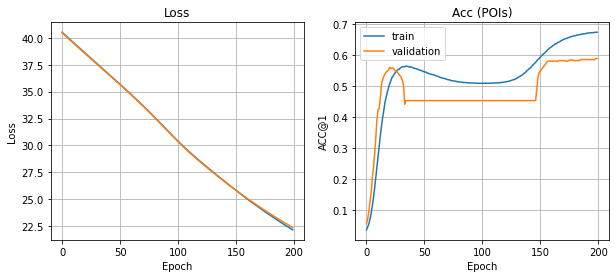

Exec time: 1.1826106627782187 min
Exec proc time: 1.1948382522 min
Test real train
4/4 [==============================] - 0s 9ms/step - loss: 22.3641 - output_day_loss: 1.8163 - output_hour_loss: 2.5587 - output_poi_loss: 1.5014 - output_day_sparse_categorical_accuracy: 0.3299 - output_hour_sparse_categorical_accuracy: 0.2330 - output_poi_sparse_categorical_accuracy: 0.5884
ACC: [day: 0.3299] [hour: 0.2330] [poi: 0.5884] (test)
ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
Exec time: 0.12590813636779785 s
Exec proc time: 0.12960916499999087 s


In [8]:
np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

npp = LSTM_TrajNPP(64, vocab_sizes)

import time
start = time.time()
start_proc = time.process_time()
npp.train(train_x, train_y, test_x, test_y, epochs=200,
           save=True, save_path="training_params/npp/breadcrumbs_npp.h5")
end = time.time()
end_proc = time.process_time()
print('Exec time:', (end-start)/60, 'min')
print('Exec proc time:', (end_proc-start_proc)/60, 'min')


print('Test real train')
start = time.time()
start_proc = time.process_time()
h = npp.evaluate(test_x, test_y, 'training_params/npp/breadcrumbs_npp.h5')
end = time.time()
end_proc = time.process_time()

dummy_evaluate(test_x, test_x[1:])

print('Exec time:', (end-start), 's')
print('Exec proc time:', (end_proc-start_proc), 's')

### Train with synth and Test with real data

In [9]:
train_file = 'further_exp/data/breadcrumbs/train_synth_s13.csv'
test_file = 'data/breadcrumbs/test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

Trajectories:   1108
Users:         80
Train size:     0.6389891696750902
Test size:      0.21660649819494585
x_train shape:  (4, 708)
y_train shape:  (3, 708)
x_test shape:   (4, 240)
y_test shape:   (3, 240)


Epoch 1/200
12/12 [==============================] - 3s 90ms/step - loss: 40.5140 - output_day_loss: 2.0837 - output_hour_loss: 2.9487 - output_poi_loss: 3.6012 - output_day_sparse_categorical_accuracy: 0.0909 - output_hour_sparse_categorical_accuracy: 0.0378 - output_poi_sparse_categorical_accuracy: 0.0223 - val_loss: 40.4612 - val_output_day_loss: 2.0840 - val_output_hour_loss: 2.9488 - val_output_poi_loss: 3.6037 - val_output_day_sparse_categorical_accuracy: 0.0527 - val_output_hour_sparse_categorical_accuracy: 0.0408 - val_output_poi_sparse_categorical_accuracy: 0.0578
Epoch 2/200
12/12 [==============================] - 0s 23ms/step - loss: 40.4137 - output_day_loss: 2.0832 - output_hour_loss: 2.9483 - output_poi_loss: 3.5978 - output_day_sparse_categorical_accuracy: 0.0920 - output_hour_sparse_categorical_accuracy: 0.0379 - output_poi_sparse_categorical_accuracy: 0.0294 - val_loss: 40.3626 - val_output_day_loss: 2.0836 - val_output_hour_loss: 2.9485 - val_output_poi_loss: 3.6015 

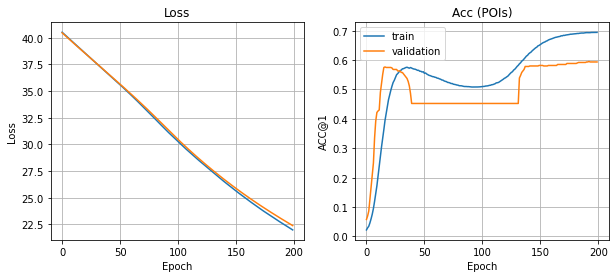

Exec time: 1.0674653887748717 min
Exec proc time: 1.1641820213166665 min
Test synth train
4/4 [==============================] - 0s 9ms/step - loss: 22.3853 - output_day_loss: 1.8069 - output_hour_loss: 2.5438 - output_poi_loss: 1.5341 - output_day_sparse_categorical_accuracy: 0.3299 - output_hour_sparse_categorical_accuracy: 0.2313 - output_poi_sparse_categorical_accuracy: 0.5935
ACC: [day: 0.3299] [hour: 0.2313] [poi: 0.5935] (test)
ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
Exec time: 0.14632582664489746 s
Exec proc time: 0.13212783100001957 s


In [10]:
np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

npp = LSTM_TrajNPP(64, vocab_sizes)

start = time.time()
start_proc = time.process_time()
npp.train(train_x, train_y, test_x, test_y, epochs=200,
           save=True, save_path="training_params/npp/breadcrumbs_npp_synth.h5")
end = time.time()
end_proc = time.process_time()
print('Exec time:', (end-start)/60, 'min')
print('Exec proc time:', (end_proc-start_proc)/60, 'min')

print('Test synth train')
start = time.time()
start_proc = time.process_time()
h = npp.evaluate(test_x, test_y, 'training_params/npp/breadcrumbs_npp_synth.h5')
end = time.time()
end_proc = time.process_time()

dummy_evaluate(test_x, test_x[1:])

print('Exec time:', (end-start), 's')
print('Exec proc time:', (end_proc-start_proc), 's')

# Foursquare (categorical POIs)

### Train and Test with real data

In [9]:
train_file = 'data/foursquare/train_cat.csv'
test_file = 'data/foursquare/test_cat.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

Trajectories:   3079
Users:         193
Train size:     0.6037674569665475
Test size:      0.2708671646638519
x_train shape:  (4, 1859)
y_train shape:  (3, 1859)
x_test shape:   (4, 834)
y_test shape:   (3, 834)


Epoch 1/20
30/30 [==============================] - 10s 46ms/step - loss: 39.4951 - output_day_loss: 2.0853 - output_hour_loss: 3.2267 - output_poi_loss: 2.3745 - output_day_sparse_categorical_accuracy: 0.0349 - output_hour_sparse_categorical_accuracy: 0.0079 - output_poi_sparse_categorical_accuracy: 0.4702 - val_loss: 39.3601 - val_output_day_loss: 2.0830 - val_output_hour_loss: 3.2241 - val_output_poi_loss: 2.3718 - val_output_day_sparse_categorical_accuracy: 0.0092 - val_output_hour_sparse_categorical_accuracy: 0.0021 - val_output_poi_sparse_categorical_accuracy: 0.8951
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 39.2413 - output_day_loss: 2.0794 - output_hour_loss: 3.2219 - output_poi_loss: 2.3703 - output_day_sparse_categorical_accuracy: 0.0661 - output_hour_sparse_categorical_accuracy: 0.0125 - output_poi_sparse_categorical_accuracy: 0.5601 - val_loss: 39.1068 - val_output_day_loss: 2.0771 - val_output_hour_loss: 3.2193 - val_output_poi_loss: 2.3675 -

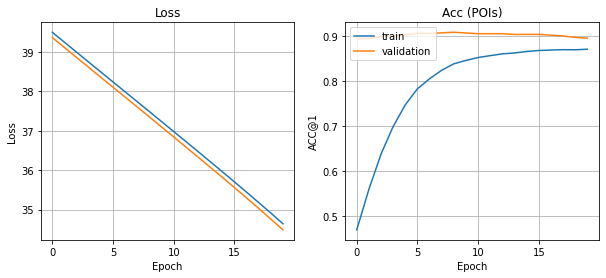

Exec time: 0.41414288282394407 min
Exec proc time: 0.33522233453333333 min
Test real train
14/14 [==============================] - 0s 10ms/step - loss: 34.4846 - output_day_loss: 1.8717 - output_hour_loss: 3.0637 - output_poi_loss: 2.1797 - output_day_sparse_categorical_accuracy: 0.8944 - output_hour_sparse_categorical_accuracy: 0.8944 - output_poi_sparse_categorical_accuracy: 0.8960
ACC: [day: 0.8944] [hour: 0.8944] [poi: 0.8960] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
Exec time: 0.39621639251708984 s
Exec proc time: 0.2406039299999989 s


In [10]:
np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

npp = LSTM_TrajNPP(64, vocab_sizes)

start, start_proc = time.time(), time.process_time()
npp.train(train_x, train_y, test_x, test_y, epochs=20,
           save=True, save_path="training_params/npp/foursquare_cat_npp.h5")
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start)/60, 'min\n' + 'Exec proc time:', (end_proc-start_proc)/60, 'min')


print('Test real train')
start, start_proc = time.time(), time.process_time()
h = npp.evaluate(test_x, test_y, 'training_params/npp/foursquare_cat_npp.h5')
end, end_proc = time.time(), time.process_time()
dummy_evaluate(test_x, test_x[1:])
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

### Train with synth and Test with real data

In [19]:
train_file = 'further_exp/data/foursquare/train_cat_synth_s13.csv'
test_file = 'data/foursquare/test_cat.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

Trajectories:   3079
Users:         193
Train size:     0.6037674569665475
Test size:      0.2708671646638519
x_train shape:  (4, 1859)
y_train shape:  (3, 1859)
x_test shape:   (4, 834)
y_test shape:   (3, 834)


Epoch 1/20
30/30 [==============================] - 4s 46ms/step - loss: 39.4963 - output_day_loss: 2.0861 - output_hour_loss: 3.2264 - output_poi_loss: 2.3752 - output_day_sparse_categorical_accuracy: 0.0312 - output_hour_sparse_categorical_accuracy: 0.0112 - output_poi_sparse_categorical_accuracy: 0.4767 - val_loss: 39.3612 - val_output_day_loss: 2.0830 - val_output_hour_loss: 3.2244 - val_output_poi_loss: 2.3725 - val_output_day_sparse_categorical_accuracy: 0.0088 - val_output_hour_sparse_categorical_accuracy: 0.0017 - val_output_poi_sparse_categorical_accuracy: 0.8917
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 39.2423 - output_day_loss: 2.0798 - output_hour_loss: 3.2215 - output_poi_loss: 2.3712 - output_day_sparse_categorical_accuracy: 0.0657 - output_hour_sparse_categorical_accuracy: 0.0160 - output_poi_sparse_categorical_accuracy: 0.5662 - val_loss: 39.1082 - val_output_day_loss: 2.0770 - val_output_hour_loss: 3.2197 - val_output_poi_loss: 2.3685 - 

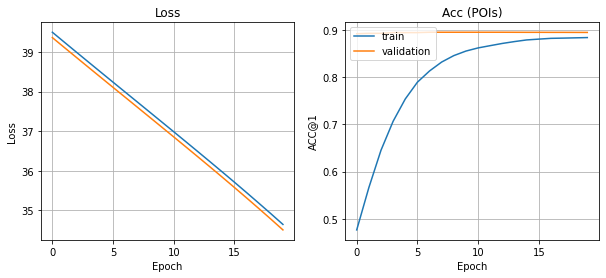

Exec time: 0.388205095132192 min
Exec proc time: 0.30509074029999966 min
Test synth train
14/14 [==============================] - 0s 10ms/step - loss: 34.5053 - output_day_loss: 1.8777 - output_hour_loss: 3.0671 - output_poi_loss: 2.1914 - output_day_sparse_categorical_accuracy: 0.8944 - output_hour_sparse_categorical_accuracy: 0.8944 - output_poi_sparse_categorical_accuracy: 0.8945
ACC: [day: 0.8944] [hour: 0.8944] [poi: 0.8945] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
Exec time: 0.23496794700622559 s
Exec proc time: 0.2349053309999931 s


In [20]:
np.random.seed(13)
python_random.seed(13)
tf.random.set_seed(13)

npp = LSTM_TrajNPP(64, vocab_sizes)

start, start_proc = time.time(), time.process_time()
npp.train(train_x, train_y, test_x, test_y, epochs=20,
           save=True, save_path="training_params/npp/foursquare_cat_npp_synth.h5")
end, end_proc = time.time(), time.process_time()
print('Exec time:', (end-start)/60, 'min\n' + 'Exec proc time:', (end_proc-start_proc)/60, 'min')

print('Test synth train')
start, start_proc = time.time(), time.process_time()
h = npp.evaluate(test_x, test_y, 'training_params/npp/foursquare_cat_npp_synth.h5')
end, end_proc = time.time(), time.process_time()
dummy_evaluate(test_x, test_x[1:])
print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

# Breadcrumbs % Data

### Train with synth Test with real

Trajectories:   709
Users:         80
Train size:     0.43582510578279265
Test size:      0.3385049365303244
x_train shape:  (4, 309)
y_train shape:  (3, 309)
x_test shape:   (4, 240)
y_test shape:   (3, 240)
Epoch 1/200
5/5 [==============================] - 3s 204ms/step - loss: 40.5425 - output_day_loss: 2.0846 - output_hour_loss: 2.9480 - output_poi_loss: 3.6048 - output_day_sparse_categorical_accuracy: 0.0865 - output_hour_sparse_categorical_accuracy: 0.0437 - output_poi_sparse_categorical_accuracy: 0.0296 - val_loss: 40.5171 - val_output_day_loss: 2.0847 - val_output_hour_loss: 2.9486 - val_output_poi_loss: 3.6032 - val_output_day_sparse_categorical_accuracy: 0.0544 - val_output_hour_sparse_categorical_accuracy: 0.0408 - val_output_poi_sparse_categorical_accuracy: 0.0170
Epoch 2/200
5/5 [==============================] - 0s 40ms/step - loss: 40.5009 - output_day_loss: 2.0845 - output_hour_loss: 2.9478 - output_poi_loss: 3.6035 - output_day_sparse_categorical_accuracy: 0.0867 - ou

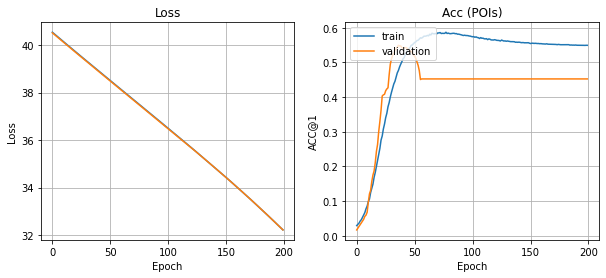

Exec time: 0.6503943959871928 min
Exec proc time: 0.670887161799999 min
Test synth train
4/4 [==============================] - 0s 12ms/step - loss: 32.2153 - output_day_loss: 2.0327 - output_hour_loss: 2.8654 - output_poi_loss: 2.7236 - output_day_sparse_categorical_accuracy: 0.2942 - output_hour_sparse_categorical_accuracy: 0.2007 - output_poi_sparse_categorical_accuracy: 0.4524
ACC: [day: 0.2942] [hour: 0.2007] [poi: 0.4524] (test)
ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
Exec time: 0.1405022144317627 s
Exec proc time: 0.13665916699994796 s
Trajectories:   549
Users:         80
Train size:     0.27140255009107467
Test size:      0.4371584699453552
x_train shape:  (4, 149)
y_train shape:  (3, 149)
x_test shape:   (4, 240)
y_test shape:   (3, 240)
Epoch 1/200
3/3 [==============================] - 3s 429ms/step - loss: 40.5528 - output_day_loss: 2.0843 - output_hour_loss: 2.9481 - output_poi_loss: 3.6056 - output_day_sparse_categorical_accuracy: 0.0939 - output_hour_spa

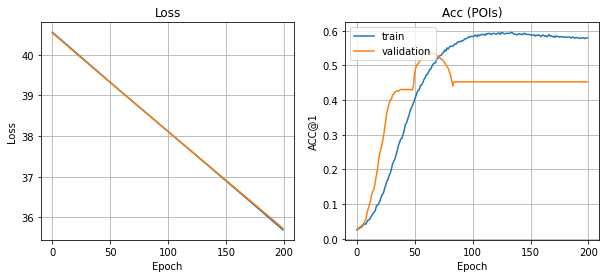

Exec time: 0.7349262873331706 min
Exec proc time: 0.5167860034 min
Test synth train
4/4 [==============================] - 0s 14ms/step - loss: 35.7352 - output_day_loss: 2.0644 - output_hour_loss: 2.9231 - output_poi_loss: 3.3926 - output_day_sparse_categorical_accuracy: 0.2942 - output_hour_sparse_categorical_accuracy: 0.1871 - output_poi_sparse_categorical_accuracy: 0.4524
ACC: [day: 0.2942] [hour: 0.1871] [poi: 0.4524] (test)
ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
Exec time: 0.14300966262817383 s
Exec proc time: 0.1354614430000538 s


In [15]:
# Percentage
percentages = [50, 30]
for p in percentages:
    train_file = 'further_exp/data/breadcrumbs/train_synth_'+str(p)+'.csv'
    test_file = 'data/breadcrumbs/test.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    npp = LSTM_TrajNPP(64, vocab_sizes)

    start = time.time()
    start_proc = time.process_time()
    npp.train(train_x, train_y, test_x, test_y, epochs=200,
            save=True, save_path="further_exp/training_params/npp/breadcrumbs_npp_synth.h5")
    end = time.time()
    end_proc = time.process_time()
    print('Exec time:', (end-start)/60, 'min')
    print('Exec proc time:', (end_proc-start_proc)/60, 'min')

    print('Test synth train')
    start = time.time()
    start_proc = time.process_time()
    h = npp.evaluate(test_x, test_y, 'further_exp/training_params/npp/breadcrumbs_npp_synth.h5')
    end = time.time()
    end_proc = time.process_time()

    dummy_evaluate(test_x, test_x[1:])

    print('Exec time:', (end-start), 's')
    print('Exec proc time:', (end_proc-start_proc), 's')

In [16]:
# # Default:
# ACC: [day: 0.3299] [hour: 0.2313] [poi: 0.5935] (test)
# ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
# # 50:
# ACC: [day: 0.2942] [hour: 0.2007] [poi: 0.4524] (test)
# ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)
# # 30:
# ACC: [day: 0.2942] [hour: 0.1871] [poi: 0.4524] (test)
# ACC: [day: 0.1804] [hour: 0.0775] [poi: 0.6324] (dummy)

# Foursquare % Data

### Train with synth Test with real

Trajectories:   1988
Users:         193
Train size:     0.386317907444668
Test size:      0.41951710261569414
x_train shape:  (4, 768)
y_train shape:  (3, 768)
x_test shape:   (4, 834)
y_test shape:   (3, 834)
Epoch 1/20
12/12 [==============================] - 3s 94ms/step - loss: 39.5676 - output_day_loss: 2.0867 - output_hour_loss: 3.2282 - output_poi_loss: 2.3760 - output_day_sparse_categorical_accuracy: 0.0341 - output_hour_sparse_categorical_accuracy: 0.0064 - output_poi_sparse_categorical_accuracy: 0.4393 - val_loss: 39.5127 - val_output_day_loss: 2.0866 - val_output_hour_loss: 3.2271 - val_output_poi_loss: 2.3743 - val_output_day_sparse_categorical_accuracy: 0.0080 - val_output_hour_sparse_categorical_accuracy: 0.0024 - val_output_poi_sparse_categorical_accuracy: 0.8936
Epoch 2/20
12/12 [==============================] - 0s 31ms/step - loss: 39.4660 - output_day_loss: 2.0843 - output_hour_loss: 3.2264 - output_poi_loss: 2.3745 - output_day_sparse_categorical_accuracy: 0.0424 - 

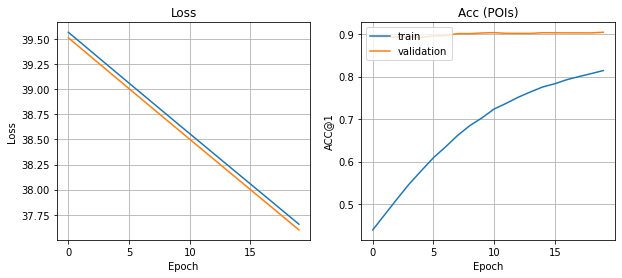

Exec time: 0.21380341053009033 min
Exec proc time: 0.1728980192333334 min
Test synth train with GAN trained on 50% data
14/14 [==============================] - 0s 10ms/step - loss: 37.5985 - output_day_loss: 2.0365 - output_hour_loss: 3.1893 - output_poi_loss: 2.3337 - output_day_sparse_categorical_accuracy: 0.8944 - output_hour_sparse_categorical_accuracy: 0.1119 - output_poi_sparse_categorical_accuracy: 0.9045
ACC: [day: 0.8944] [hour: 0.1119] [poi: 0.9045] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
Exec time: 0.3865926265716553 s
Exec proc time: 0.23199026200001072 s
Trajectories:   1574
Users:         193
Train size:     0.22490470139771285
Test size:      0.5298602287166455
x_train shape:  (4, 354)
y_train shape:  (3, 354)
x_test shape:   (4, 834)
y_test shape:   (3, 834)
Epoch 1/20
6/6 [==============================] - 3s 185ms/step - loss: 39.5944 - output_day_loss: 2.0871 - output_hour_loss: 3.2288 - output_poi_loss: 2.3761 - output_day_sparse_categorical_

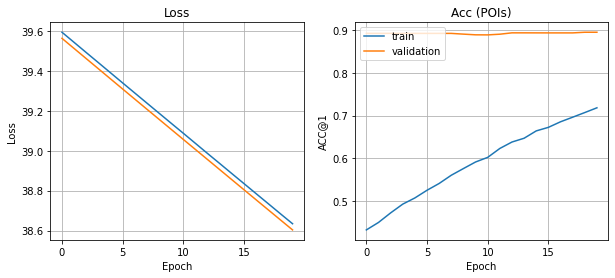

Exec time: 0.1367647131284078 min
Exec proc time: 0.14793388783333322 min
Test synth train with GAN trained on 30% data
14/14 [==============================] - 0s 8ms/step - loss: 38.6031 - output_day_loss: 2.0648 - output_hour_loss: 3.2099 - output_poi_loss: 2.3582 - output_day_sparse_categorical_accuracy: 0.8927 - output_hour_sparse_categorical_accuracy: 0.0133 - output_poi_sparse_categorical_accuracy: 0.8945
ACC: [day: 0.8927] [hour: 0.0133] [poi: 0.8945] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
Exec time: 0.20154333114624023 s
Exec proc time: 0.23114355999996405 s


In [17]:
# Percentage
percentages = [50, 30]
for p in percentages:

    train_file = 'further_exp/data/foursquare/train_cat_synth_'+str(p)+'.csv'
    test_file = 'data/foursquare/test_cat.csv'

    df_train = pd.read_csv(train_file)
    df_test = pd.read_csv(test_file)

    # df_train = traj_percentage(df_test, p)

    train_x, train_y, test_x, test_y, vocab_sizes, vocab_encod, vocab_centroid = preproc_trajnpp(df_train, df_test)

    np.random.seed(13)
    python_random.seed(13)
    tf.random.set_seed(13)

    npp = LSTM_TrajNPP(64, vocab_sizes)

    start, start_proc = time.time(), time.process_time()
    npp.train(train_x, train_y, test_x, test_y, epochs=20,
            save=True, save_path='further_exp/training_params/npp/foursquare_cat_npp_synth.h5')
    end, end_proc = time.time(), time.process_time()
    print('Exec time:', (end-start)/60, 'min\n' + 'Exec proc time:', (end_proc-start_proc)/60, 'min')


    print(f'Test synth train with GAN trained on {p}% data')
    start, start_proc = time.time(), time.process_time()
    h = npp.evaluate(test_x, test_y, 'further_exp/training_params/npp/foursquare_cat_npp_synth.h5')
    end, end_proc = time.time(), time.process_time()
    dummy_evaluate(test_x, test_x[1:])
    print('Exec time:', (end-start), 's\n' + 'Exec proc time:', (end_proc-start_proc), 's')

In [18]:
# # Default:
ACC: [day: 0.8944] [hour: 0.8944] [poi: 0.8945] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
# # 50:
ACC: [day: 0.8944] [hour: 0.1119] [poi: 0.9045] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)
# # 30:
ACC: [day: 0.8927] [hour: 0.0133] [poi: 0.8945] (test)
ACC: [day: 0.3073] [hour: 0.1948] [poi: 0.6086] (dummy)